In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Load signal sample into memory
with uproot.open("ntuples/dataset_mu200_ztt1000_10k.root:fastjet") as f:
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_pufr_sig = f["jet_pufr_truth"].array()
    jet_idx_sig = f["jet_ttbar_match"].array()
    jet_label_sig = np.ones(len(jet_pt_sig))

# Load background sample into memory
with uproot.open("ntuples/dataset_mu200_ttbar_10k.root:fastjet") as f:
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_pufr_bkg = f["jet_pufr_truth"].array()
    jet_idx_bkg = f["jet_ttbar_match"].array()
    jet_label_bkg = np.zeros(len(jet_pt_bkg))

In [3]:
# crazy vectorized syntax https://awkward-array.org/doc/main/user-guide/how-to-restructure-concatenate.html#emulating-numpy-s-stack-functions
jet_sig = ak.concatenate([jet_pt_sig[:, :, np.newaxis], jet_eta_sig[:, :, np.newaxis], jet_phi_sig[:, :, np.newaxis], jet_m_sig[:, :, np.newaxis], jet_pufr_sig[:, :, np.newaxis]], axis=2)
jet_bkg = ak.concatenate([jet_pt_bkg[:, :, np.newaxis], jet_eta_bkg[:, :, np.newaxis], jet_phi_bkg[:, :, np.newaxis], jet_m_bkg[:, :, np.newaxis], jet_pufr_bkg[:, :, np.newaxis]], axis=2)

# combine sig and bkg into one vector
jet_feats = ak.concatenate([jet_sig, jet_bkg], axis=0)
jet_labels = np.concatenate([jet_label_sig,jet_label_bkg], axis=0)
jet_idx = np.array(ak.concatenate([jet_idx_sig, jet_idx_bkg], axis=0))

In [4]:
shuffled_idx = np.random.permutation(len(jet_feats))
jet_feats = jet_feats[shuffled_idx]
jet_labels = jet_labels[shuffled_idx]

sig = (jet_labels==1)    
bkg = ~sig

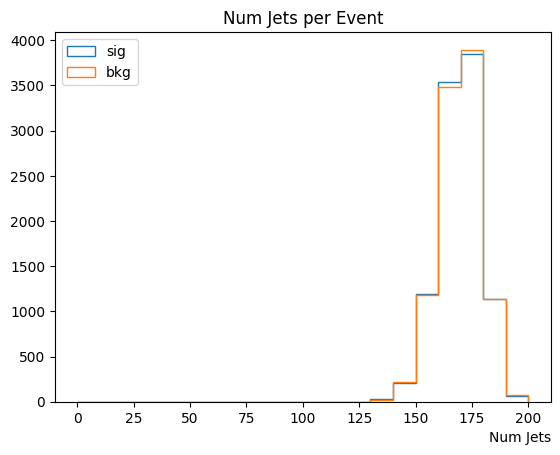

In [5]:
h_num_jets = ak.num(jet_feats,axis=1)
plt.title('Num Jets per Event')
plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=20,range=(0,ak.max(h_num_jets)))
plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=20,range=(0,ak.max(h_num_jets)))
plt.xlabel('Num Jets',loc='right')
plt.legend()
plt.show()

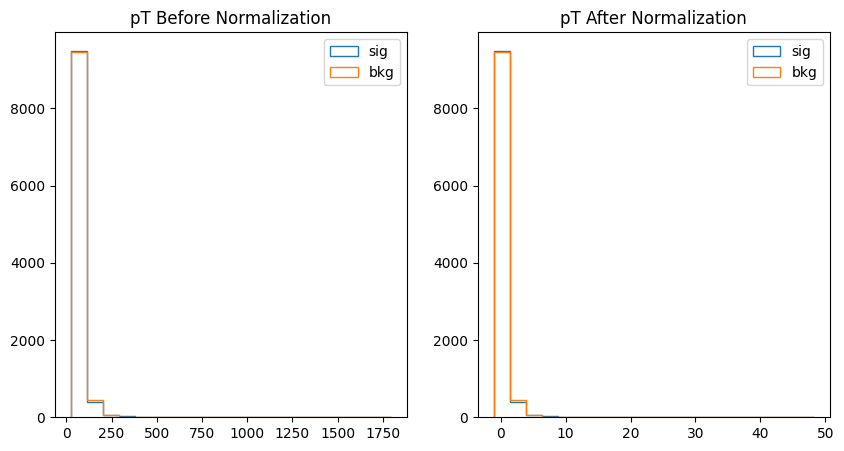

Before Mean:  64.19962523792321
Before STD:  35.89002029274455
After Mean:  -0.0003666689149096745
After STD:  0.9989196936007443


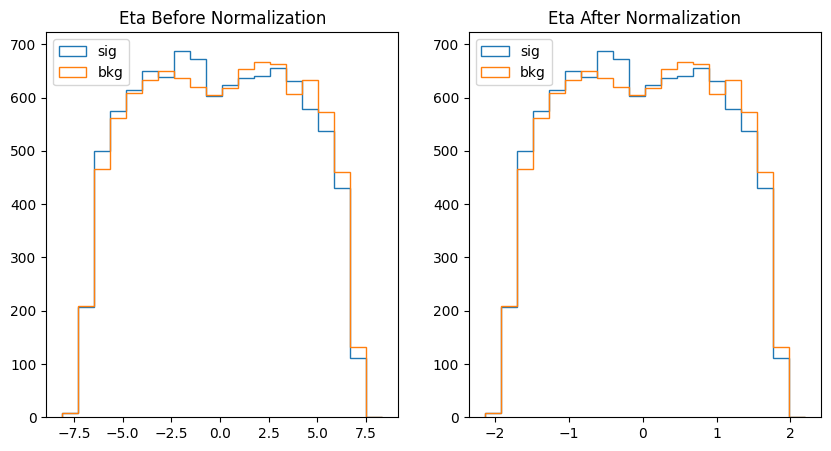

Before Mean:  7.497563457304269e-05
Before STD:  3.790807766259517
After Mean:  -3.863411273359681e-09
After STD:  1.0005655554889479


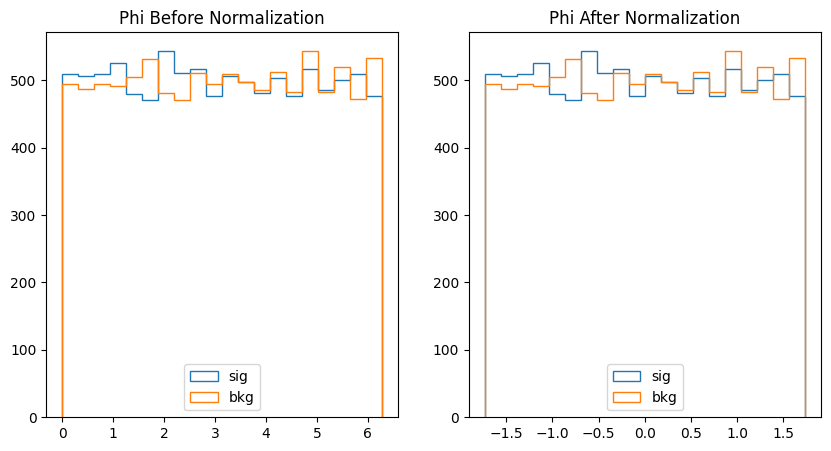

Before Mean:  3.139813928727605
Before STD:  1.8124625244055577
After Mean:  0.0009277853926114192
After STD:  1.0008566418264029


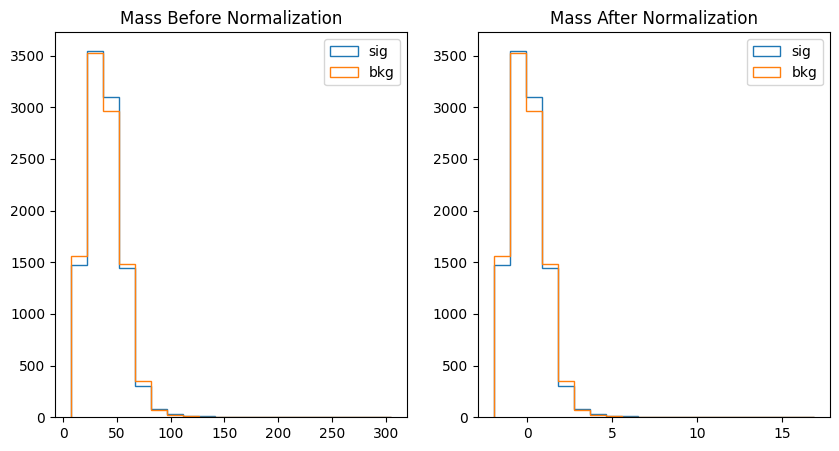

Before Mean:  38.36128162715187
Before STD:  15.809671991288154
After Mean:  0.00018904451350937448
After STD:  0.9998161801790084


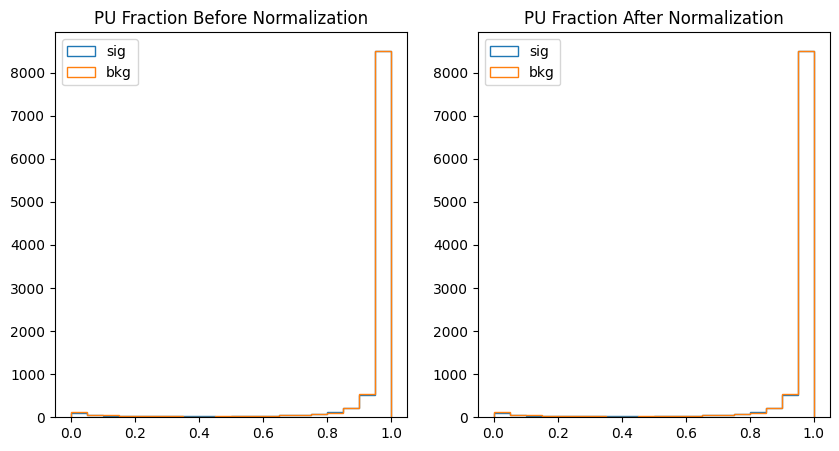

Before Mean:  0.9493871562656458
Before STD:  0.15758437495321126
After Mean:  0.9465708794319434
After STD:  0.16719445331848545


/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [6]:
# Split dataset into train, val, test split
data = jet_feats
labels = jet_labels
num_events = len(data)
X_train_raw = data[0:int(0.7*num_events)]
y_train = labels[0:int(0.7*num_events)].reshape(-1,1)
X_val_raw = data[int(0.7*num_events):int(0.75*num_events)]
y_val = labels[int(0.7*num_events):int(0.75*num_events)].reshape(-1,1)
X_test_raw = data[int(0.75*num_events):]
y_test = labels[int(0.75*num_events):].reshape(-1,1)

# Calculate the mean and std of each feature
num_feats = len(jet_feats[0][0])
X_train_means = []
X_train_stds = []
for i in range(num_feats):
    X_train_means.append(ak.mean(X_train_raw[:,:,i]))
    X_train_stds.append(ak.std(X_train_raw[:,:,i]))
# Do not apply mean and std to pufr
X_train_means[-1]=0
X_train_stds[-1]=1

# Normalize dataset
X_train_norm = []
X_val_norm = []
X_test_norm = []
for i in range(num_feats):
    X_train_norm.append(ak.Array((X_train_raw[:,:,i] - X_train_means[i]) / X_train_stds[i])[:, :, np.newaxis])
    X_val_norm.append(ak.Array((X_val_raw[:,:,i] - X_train_means[i]) / X_train_stds[i])[:, :, np.newaxis])
    X_test_norm.append(ak.Array((X_test_raw[:,:,i] - X_train_means[i]) / X_train_stds[i])[:, :, np.newaxis])
X_train_norm = ak.concatenate(X_train_norm, axis=2)
X_val_norm = ak.concatenate(X_val_norm, axis=2)
X_test_norm = ak.concatenate(X_test_norm, axis=2)
        
# Validation plots
var_list = ['pT','Eta','Phi','Mass','PU Fraction']
for i in range(len(var_list)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    var1 = ak.flatten(X_train_raw[:,:,i])
    mini=ak.min(var1)
    maxi=ak.max(var1)
    ax1.hist(var1[sig],histtype='step',label='sig',bins=20,range=(mini,maxi))
    ax1.hist(var1[bkg],histtype='step',label='bkg',bins=20,range=(mini,maxi))
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    var2 = ak.flatten(X_train_norm[:,:,i])
    mini=ak.min(var2)
    maxi=ak.max(var2)
    ax2.hist(var2[sig],histtype='step',label='sig',bins=20,range=(mini,maxi))
    ax2.hist(var2[bkg],histtype='step',label='bkg',bins=20,range=(mini,maxi))
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    plt.show()
    print("Before Mean: ", np.mean(var1))
    print("Before STD: ", np.std(var1))
    print("After Mean: ", np.mean(var2))
    print("After STD: ", np.std(var2))

# Convert to torch.Tensor()
X_train = torch.nested.nested_tensor(ak.to_list(X_train_norm))
y_train = torch.Tensor(y_train)
X_val = torch.nested.nested_tensor(ak.to_list(X_val_norm))
y_val = torch.Tensor(y_val)
X_test = torch.nested.nested_tensor(ak.to_list(X_test_norm))
y_test = torch.Tensor(y_test)

X_train_baseline = torch.nested.nested_tensor(ak.to_list(X_train_norm[:,:,0:4]))
X_val_baseline = torch.nested.nested_tensor(ak.to_list(X_val_norm[:,:,0:4]))
X_test_baseline = torch.nested.nested_tensor(ak.to_list(X_test_norm[:,:,0:4]))

In [7]:
class Model(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Model, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.jet_postprocess = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))
        jet_aggregated = jet_embedding.sum(dim=0)
        output = F.sigmoid(self.jet_postprocess(jet_aggregated))
        return output

In [8]:
def train(model, data, epochs=20):
    X_train, y_train, X_val, y_val = data
    
    history = {'train_loss':[],'test_loss':[]}

    cum_loss_train = []
    cum_loss_val = []
    
    for e in range(epochs):     
        num_train = X_train.size(0)
        model.train()
        for event in range(num_train):
            optimizer.zero_grad()
            output = model(X_train[event].to(device))
            loss = loss_fn(output, y_train[event].to(device))
            loss.backward()
            optimizer.step()
            cum_loss_train.append(loss.detach().cpu().numpy())
        
        num_val = X_val.size(0)
        model.eval()
        for event in range(num_val):
            y_pred = model(X_val[event].to(device))
            loss = loss_fn(y_pred,y_val[event].to(device))
            cum_loss_val.append(loss.detach().cpu().numpy())

        history['train_loss'].append(np.mean(cum_loss_train))
        history['test_loss'].append(np.mean(cum_loss_val))

        if (e+1)%10==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(np.mean(cum_loss_train)),4),'\tTest Loss:',round(float(np.mean(cum_loss_val)),4))

    return history   

In [9]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


Training Baseline
Epoch: 10 	Train Loss: 0.6166 	Test Loss: 0.5246
Epoch: 20 	Train Loss: 0.6039 	Test Loss: 0.5222
Epoch: 30 	Train Loss: 0.5951 	Test Loss: 0.5215
Epoch: 40 	Train Loss: 0.5881 	Test Loss: 0.5215
Epoch: 50 	Train Loss: 0.5823 	Test Loss: 0.5214
Epoch: 60 	Train Loss: 0.5773 	Test Loss: 0.5212
Epoch: 70 	Train Loss: 0.5729 	Test Loss: 0.521
Epoch: 80 	Train Loss: 0.5691 	Test Loss: 0.521
Epoch: 90 	Train Loss: 0.5658 	Test Loss: 0.5209
Epoch: 100 	Train Loss: 0.5629 	Test Loss: 0.5208

Training Proposed
Epoch: 10 	Train Loss: 0.6293 	Test Loss: 0.522
Epoch: 20 	Train Loss: 0.6131 	Test Loss: 0.5185
Epoch: 30 	Train Loss: 0.6012 	Test Loss: 0.5172
Epoch: 40 	Train Loss: 0.5921 	Test Loss: 0.5168
Epoch: 50 	Train Loss: 0.5848 	Test Loss: 0.5162
Epoch: 60 	Train Loss: 0.5788 	Test Loss: 0.5157
Epoch: 70 	Train Loss: 0.5738 	Test Loss: 0.5153
Epoch: 80 	Train Loss: 0.5694 	Test Loss: 0.515
Epoch: 90 	Train Loss: 0.5655 	Test Loss: 0.5147
Epoch: 100 	Train Loss: 0.5622 	Tes

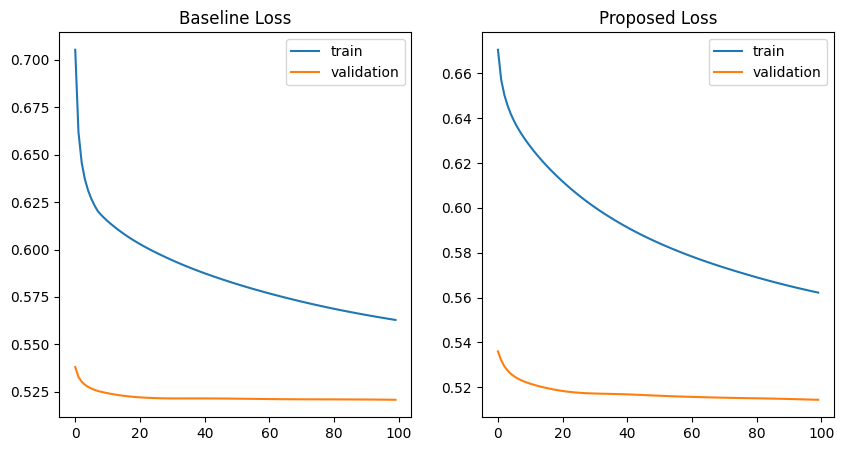

In [11]:
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.BCELoss()

# Train baseline model with pt,eta,phi,m
print("Training Baseline")
baseline = Model(4,256,1).to(device)
optimizer = optim.Adam(baseline.parameters(), lr=0.0001)
data = [X_train_baseline, y_train, X_val_baseline, y_val]
baseline_history = train(baseline, data, epochs=100)
print()

# Train upgraded model with pt,eta,phi,m,pufr
print("Training Proposed")
model = Model(5,256,1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
data = [X_train, y_train, X_val, y_val]
model_history = train(model, data, epochs=100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(baseline_history['train_loss'],label='train')
ax1.plot(baseline_history['test_loss'],label='validation')
ax1.set_title("Baseline Loss")
ax1.legend()
ax2.plot(model_history['train_loss'],label='train')
ax2.plot(model_history['test_loss'],label='validation')
ax2.set_title("Proposed Loss")
ax2.legend()
plt.show()

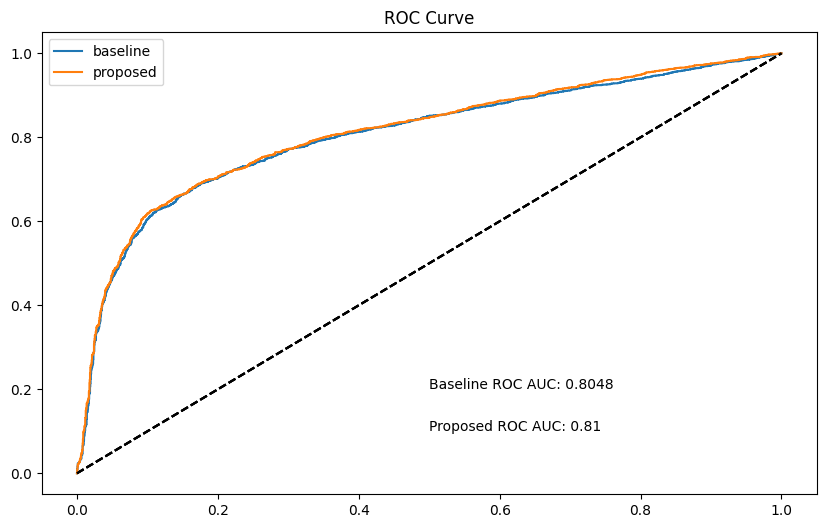

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))

num_test = X_test.size(0)

baseline.to(device)
baseline.eval()
y_pred = []
for event in range(num_test):
    y_pred.append(baseline(X_test_baseline[event].to(device)).detach().cpu().numpy())
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax1.plot(fpr,tpr, label="baseline")
ax1.plot([[0,0],[1,1]],'--',color='k')
AUC = "Baseline ROC AUC: " + str(round(roc_auc_score(y_test, y_pred),4))
ax1.text(0.5,0.2,AUC)

model.to(device)
model.eval()
y_pred = []
for event in range(num_test):
    y_pred.append(model(X_test[event].to(device)).detach().cpu().numpy())
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax1.plot(fpr,tpr, label="proposed")
ax1.plot([[0,0],[1,1]],'--',color='k')
ax1.set_title("ROC Curve")
AUC = "Proposed ROC AUC: " + str(round(roc_auc_score(y_test, y_pred),4))
ax1.text(0.5,0.1,AUC)
ax1.legend()
plt.show()